<a href="https://colab.research.google.com/github/ccarpenterg/introNLP/blob/master/03a_NLP_and_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP and Recurrent Neural Networks

In [1]:
# load Tensorflow 2
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow import keras

import tensorflow_datasets as tfds
import numpy as np

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


## Sentiment Analysis of IMDB Movie Reviews

In [0]:
train_validation_split = tfds.Split.TRAIN.subsplit([8, 2])

(train_validation_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (train_validation_split, tfds.Split.TEST),
    as_supervised=True,
    with_info=True
)

train_data, validation_data = train_validation_data

In [0]:
encoder = info.features['text'].encoder

## Preprocessing the Dataset with Padding

In [0]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_data))
)

validation_batches = (
    validation_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(validation_data))
)

test_batches = (
    test_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))
)

In [5]:
for batch_example, labels in train_batches.take(2):
    print("Batch shape:", batch_example.shape)
    print("Labels shape:", labels.shape)

Batch shape: (32, 1314)
Labels shape: (32,)
Batch shape: (32, 1482)
Labels shape: (32,)


## Sequence Processing with a Recurrent Neural Network

In [6]:
model_v1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 561,089
Trainable params: 561,089
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_v2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


**Embeding layer**



**LSTM layer**

Cell: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Update gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Forget gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Output gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

**Bidirectional**

Forward LSTM: 33,024 parameters

Backward LSTM: 33,024 parameters

Total: 66,048 parameters

**FC layer**

The bidirectional layer outputs two activationn vectors, one for the forward LSTM and one for the backward LTSM, that gives us 128 activation units.

64 * 128 weigths + 64 biases = 8,256 parameters

**Dense classifier layer**

1 * 64 weights + 1 bias = 64 parameters

In [8]:
model_v3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 697,025
Trainable params: 697,025
Non-trainable params: 0
_________________________________________________________________


## Training Our RNNs

In [0]:
EPOCHS = 10
VAL_STEPS = 30
results = {}

In [10]:
model_v1.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=['accuracy'])

results['v1'] = model_v1.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 43s 69ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4865
Epoch 2/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6934 - val_accuracy: 0.4865
Epoch 3/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6928 - accuracy: 0.5066 - val_loss: 0.6935 - val_accuracy: 0.5115
Epoch 4/10
625/625 [==============================] - 34s 55ms/step - loss: 0.6916 - accuracy: 0.5039 - val_loss: 0.6941 - val_accuracy: 0.4865
Epoch 5/10
625/625 [==============================] - 34s 55ms/step - loss: 0.6890 - accuracy: 0.5097 - val_loss: 0.6940 - val_accuracy: 0.4885
Epoch 6/10
625/625 [==============================] - 34s 55ms/step - loss: 0.6844 - accuracy: 0.5148 - val_loss: 0.6913 - val_accuracy: 0.4917
Epoch 7/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6810 - accuracy: 0.5166 - val_loss: 0.6905 - val_accuracy:

In [11]:
test_loss, test_accuracy = model_v1.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.6931630216748513
Test Accuracy: 0.5111200213432312


In [12]:
model_v2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

results['v2'] = model_v2.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 58s 93ms/step - loss: 0.6045 - accuracy: 0.6488 - val_loss: 0.3723 - val_accuracy: 0.8458
Epoch 2/10
625/625 [==============================] - 55s 89ms/step - loss: 0.3129 - accuracy: 0.8748 - val_loss: 0.2854 - val_accuracy: 0.8771
Epoch 3/10
625/625 [==============================] - 56s 90ms/step - loss: 0.2336 - accuracy: 0.9146 - val_loss: 0.2819 - val_accuracy: 0.8844
Epoch 4/10
625/625 [==============================] - 56s 90ms/step - loss: 0.2045 - accuracy: 0.9284 - val_loss: 0.3589 - val_accuracy: 0.8354
Epoch 5/10
625/625 [==============================] - 58s 92ms/step - loss: 0.1736 - accuracy: 0.9391 - val_loss: 0.3077 - val_accuracy: 0.8771
Epoch 6/10
625/625 [==============================] - 57s 90ms/step - loss: 0.1418 - accuracy: 0.9528 - val_loss: 0.3301 - val_accuracy: 0.8719
Epoch 7/10
625/625 [==============================] - 56s 90ms/step - loss: 0.1283 - accuracy: 0.9600 - val_loss: 0.3810 - val_accuracy:

In [13]:
test_loss, test_accuracy = model_v2.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.5050588227960917
Test Accuracy: 0.8480799794197083


In [14]:
model_v3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

results['v3'] = model_v3.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 106s 169ms/step - loss: 0.5851 - accuracy: 0.6605 - val_loss: 0.4403 - val_accuracy: 0.7896
Epoch 2/10
625/625 [==============================] - 100s 161ms/step - loss: 0.3528 - accuracy: 0.8543 - val_loss: 0.3818 - val_accuracy: 0.8344
Epoch 3/10
625/625 [==============================] - 102s 163ms/step - loss: 0.3170 - accuracy: 0.8780 - val_loss: 0.3772 - val_accuracy: 0.8417
Epoch 4/10
625/625 [==============================] - 102s 164ms/step - loss: 0.2238 - accuracy: 0.9212 - val_loss: 0.3235 - val_accuracy: 0.8677
Epoch 5/10
625/625 [==============================] - 102s 163ms/step - loss: 0.1771 - accuracy: 0.9430 - val_loss: 0.3713 - val_accuracy: 0.8573
Epoch 6/10
625/625 [==============================] - 101s 162ms/step - loss: 0.1547 - accuracy: 0.9520 - val_loss: 0.3782 - val_accuracy: 0.8740
Epoch 7/10
625/625 [==============================] - 101s 162ms/step - loss: 0.1335 - accuracy: 0.9604 - val_loss: 0.3760 -

In [15]:
test_loss, test_accuracy = model_v3.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.499510610504719
Test Accuracy: 0.8415200114250183


In [0]:
import matplotlib.pyplot as plt

def plot_stats(training_results):

    training_dict = training_results.history

    acc = training_dict['accuracy']
    val_acc = training_dict['val_accuracy']
    loss = training_dict['loss']
    val_loss = training_dict['val_loss']

    epochs = range(1, EPOCHS + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

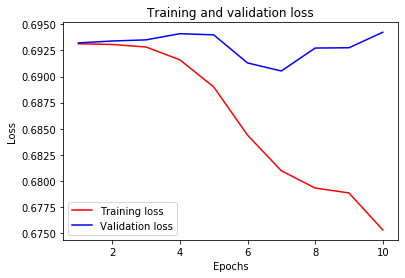

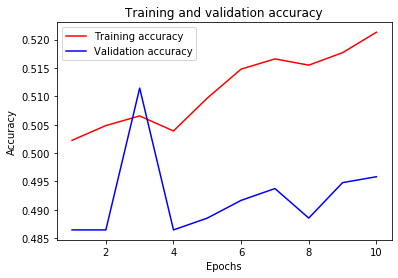

In [17]:
plot_stats(results['v1'])

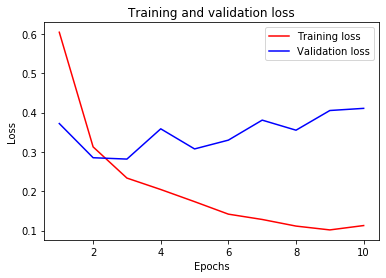

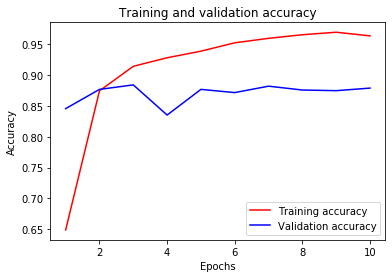

In [18]:
plot_stats(results['v2'])

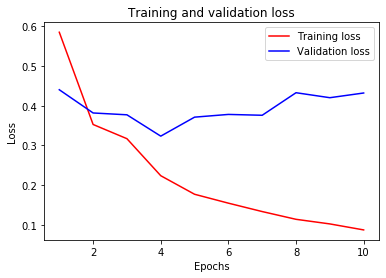

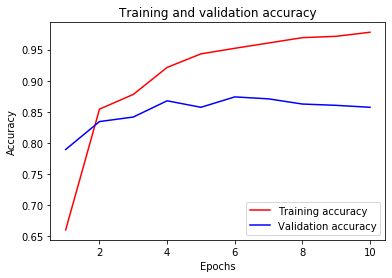

In [19]:
plot_stats(results['v3'])